In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
from PIL import Image
import tensorflow as tf
# import the necessary packages
#from . import config

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from imutils import paths


In [11]:

data_dir = "H://tmp//deepLearning//datasets/BSR"


In [43]:
# CONFIG 

# specify root path to the BSDS500 dataset
ROOT_PATH = os.path.join(data_dir, "BSDS500", "images")
# specify paths to the different splits of the dataset
TRAIN_SET = os.path.join(ROOT_PATH, "train")
VAL_SET = os.path.join(ROOT_PATH, "val")
TEST_SET = os.path.join(ROOT_PATH, "test")
# specify the initial size of the images and downsampling factor
ORIG_SIZE = (300, 300)

DOWN_FACTOR = 3
# specify number of RDB blocks, batch size, number of epochs, and
# initial learning rate to train our model
RDB_LAYERS = 3
BATCH_SIZE = 8
EPOCHS = 100
LR = 1e-3
#define paths to serialize trained model, training history plot, and
# path to our inference visualizations
SUPER_RES_MODEL = os.path.join(data_dir,"output", "super_res_model")
TRAINING_PLOT = os.path.join(data_dir,"output", "training.png")
VISUALIZATION_PATH = os.path.join(data_dir,"output", "visualizations")

In [30]:

def process_input(imagePath, downFactor=DOWN_FACTOR):
    # determine size of the downsampled images
    resizeShape = ORIG_SIZE[0] // downFactor
    # load the original image from disk, decode it as a JPEG image,
    # scale its pixel values to [0, 1] range, and resize the image
    origImage = tf.io.read_file(imagePath)
    origImage = tf.image.decode_jpeg(origImage, 3)
    origImage = tf.image.convert_image_dtype(origImage, tf.float32)
    origImage = tf.image.resize(origImage, ORIG_SIZE,method="area")
    # convert the color space from RGB to YUV and only keep the Y
    # channel (which is our target variable)
    origImageYUV = tf.image.rgb_to_yuv(origImage)
    (target, _, _) = tf.split(origImageYUV, 3, axis=-1)
    # resize the target to a lower resolution
    downImage = tf.image.resize(target, [resizeShape, resizeShape],
        method="area")
    # clip the values of the input and target to [0, 1] range
    target = tf.clip_by_value(target, 0.0, 1.0)
    downImage = tf.clip_by_value(downImage, 0.0, 1.0)
    # return a tuple of the downsampled image and original image
    return (downImage, target)


In [31]:
def rdb_block(inputs, numLayers):
    # determine the number of channels present in the current input
    # and initialize a list with the current inputs for concatenation
    channels = inputs.get_shape()[-1]
    storedOutputs = [inputs]
    # iterate through the number of residual dense layers
    for _ in range(numLayers):
        # concatenate the previous outputs and pass it through a
        # CONV layer, and append the output to the ongoing concatenation
        localConcat = tf.concat(storedOutputs, axis=-1)
        out = Conv2D(filters=channels, kernel_size=3, padding="same",
            activation="relu",
            kernel_initializer="Orthogonal")(localConcat)
        storedOutputs.append(out)
    # concatenate all the outputs, pass it through a pointwise
    # convolutional layer, and add the outputs to initial inputs
    finalConcat = tf.concat(storedOutputs, axis=-1)
    finalOut = Conv2D(filters=inputs.get_shape()[-1], kernel_size=1,
        padding="same", activation="relu",
        kernel_initializer="Orthogonal")(finalConcat)
    finalOut = Add()([finalOut, inputs])
    # return the final output
    return finalOut


In [14]:
def smish(input):
    return input * tf.math.tanh(tf.math.log(1+tf.math.sigmoid(input)))


In [32]:
def get_subpixel_net(downsampleFactor=DOWN_FACTOR, channels=1,
    rdbLayers=RDB_LAYERS):
    # initialize an input layer
    inputs = Input((None, None, 1))
    #--------------------------------------------------------
    self_block_1 = DoubleConvBlock(3, 16, 16, stride=2,)
    self_block_2 = DoubleConvBlock(16, 32, use_act=False)
    self_dblock_3 = _DenseBlock(1, 32, 48) # [32,48,100,100] before (2, 32, 64)
    self_maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # skip1 connection, see fig. 2
    self_side_1 = SingleConvBlock(16, 32, 2)
    # skip2 connection, see fig. 2
    self_pre_dense_3 = SingleConvBlock(32, 48, 1)  # before (32, 64, 1)
    # USNet
    self_up_block_1 = UpConvBlock(16, 1)
    self_up_block_2 = UpConvBlock(32, 1)
    self_up_block_3 = UpConvBlock(48, 2) # (32, 64, 1)
    self_concatenate_1 = Concatenate(axis=3)
    #-----------------------------------------------------------
    
 
    block_1 = self_block_1(inputs) # [8,16,176,176]
    block_1_side = self_side_1(block_1) # 16 [8,32,88,88]
    # Block 2
    block_2 = self_block_2(block_1) # 32 # [8,32,176,176]
    block_2_down = self_maxpool(block_2) # [8,32,88,88]
    block_2_add = block_2_down + block_1_side # [8,32,88,88]
    # Block 3
    block_3_pre_dense = self_pre_dense_3(block_2_down) # [8,64,88,88] block 3 L connection
    block_3, _ = self_dblock_3([block_2_add, block_3_pre_dense]) # [8,64,88,88]
    # upsampling blocks
    out_1 = self_up_block_1(block_1)
    out_2 = self_up_block_2(block_2)
    out_3 = self_up_block_3(block_3)
    results = [out_1, out_2, out_3]
    # concatenate multiscale outputs
    concatenate_1 = self_concatenate_1(results)
    
    # pass the outputs through an RDB => CONV => RDB block
    x = rdb_block(x, numLayers=rdbLayers)
    x = Conv2D(32, 3, padding="same", activation="relu",
        kernel_initializer="Orthogonal")(x)
    x = rdb_block(x, numLayers=rdbLayers)
    # pass the inputs through a final CONV layer such that the
    # channels of the outputs can be spatially organized into
    # the output resolution
    x = Conv2D(channels * (downsampleFactor ** 2), 3, padding="same",
        activation="relu", kernel_initializer="Orthogonal")(x)
    outputs = tf.nn.depth_to_space(x, downsampleFactor)
    # construct the final model and return it
    
    
    
    
    model = Model(inputs, outputs)
    return model    

In [33]:

def psnr(orig, pred):
    # cast the target images to integer
    orig = orig * 255.0
    orig = tf.cast(orig, tf.uint8)
    orig = tf.clip_by_value(orig, 0, 255)
    # cast the predicted images to integer
    pred = pred * 255.0
    pred = tf.cast(pred, tf.uint8)
    pred = tf.clip_by_value(pred, 0, 255)
    # return the psnr
    return tf.image.psnr(orig, pred, max_val=255)

In [45]:
# define autotune flag for performance optimization
AUTO = tf.data.AUTOTUNE
# load the image paths from disk and initialize TensorFlow Dataset
# objects
print("[INFO] loading images from disk...")
trainPaths = list(paths.list_images(TRAIN_SET))
valPaths = list(paths.list_images(VAL_SET))
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
valDS = tf.data.Dataset.from_tensor_slices(valPaths)
#Pixel Shuffle Super Resolution with TensorFlow, Keras, and Deep Learning
# prepare data loaders
print("[INFO] preparing data loaders...")
trainDS = trainDS.map(process_input,
                    num_parallel_calls=AUTO).batch(
    BATCH_SIZE).prefetch(AUTO)
valDS = valDS.map(process_input,
                      num_parallel_calls=AUTO).batch(
    BATCH_SIZE).prefetch(AUTO)
# initialize, compile, and train the model
print("[INFO] initializing and training model...")
model = get_subpixel_net()
model.compile(optimizer="adam", loss="mse", metrics=psnr)
H = model.fit(trainDS, validation_data=valDS, epochs=EPOCHS)


[INFO] loading images from disk...
[INFO] preparing data loaders...
[INFO] initializing and training model...
Epoch 1/100
25/25 [==============================] - 10s 97ms/step - loss: 0.0955 - psnr: 10.7995 - val_loss: 0.0600 - val_psnr: 12.4475
Epoch 2/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0499 - psnr: 13.3363 - val_loss: 0.0221 - val_psnr: 15.7561
Epoch 3/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0089 - psnr: 20.0454 - val_loss: 0.0070 - val_psnr: 19.2314
Epoch 4/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0051 - psnr: 22.4548 - val_loss: 0.0044 - val_psnr: 23.1785
Epoch 5/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0038 - psnr: 23.7141 - val_loss: 0.0037 - val_psnr: 21.9643
Epoch 6/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0033 - psnr: 24.1204 - val_loss: 0.0034 - val_psnr: 24.4386
Epoch 7/100
25/25 [==============================] - 2s 70ms/step - loss:

25/25 [==============================] - 2s 69ms/step - loss: 0.0021 - psnr: 26.3641 - val_loss: 0.0022 - val_psnr: 24.5027
Epoch 61/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0020 - psnr: 26.3450 - val_loss: 0.0022 - val_psnr: 26.2278
Epoch 62/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0021 - psnr: 26.3491 - val_loss: 0.0022 - val_psnr: 24.4902
Epoch 63/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0020 - psnr: 26.3520 - val_loss: 0.0022 - val_psnr: 26.2374
Epoch 64/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0020 - psnr: 26.3784 - val_loss: 0.0022 - val_psnr: 24.4930
Epoch 65/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0020 - psnr: 26.3685 - val_loss: 0.0022 - val_psnr: 26.2664
Epoch 66/100
25/25 [==============================] - 2s 66ms/step - loss: 0.0020 - psnr: 26.3794 - val_loss: 0.0021 - val_psnr: 24.5197
Epoch 67/100
25/25 [==============================] - 

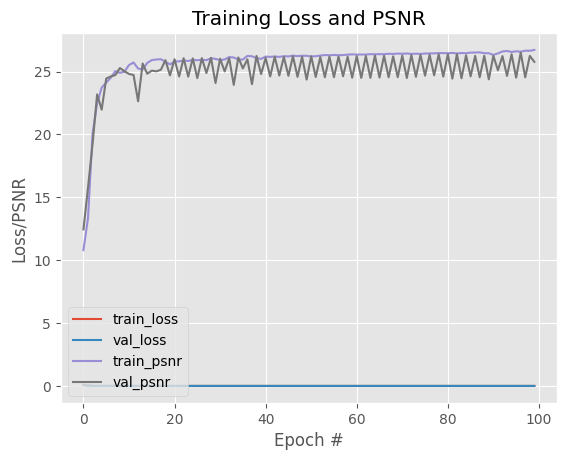

In [47]:

#Pixel Shuffle Super Resolution with TensorFlow, Keras, and Deep Learning
# prepare training plot of the model and serialize it
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["psnr"], label="train_psnr")
plt.plot(H.history["val_psnr"], label="val_psnr")
plt.title("Training Loss and PSNR")
plt.xlabel("Epoch #")
plt.ylabel("Loss/PSNR")
plt.legend(loc="lower left")
#plt.savefig(TRAINING_PLOT)


In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1664        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                           

__________________________________________________________________________________________________


In [49]:
# serialize the trained model
print("[INFO] serializing model...")
model.save(SUPER_RES_MODEL)

[INFO] serializing model...


INFO:tensorflow:Assets written to: H://tmp//deepLearning//datasets/BSR\output\super_res_model/assets


INFO:tensorflow:Assets written to: H://tmp//deepLearning//datasets/BSR\output\super_res_model/assets


In [65]:

def load_image(imagePath):
    # load image from disk and downsample it using the bicubic method
    orig = load_img(imagePath)
    downsampled = orig.resize((orig.size[0] // DOWN_FACTOR,
        orig.size[1] // DOWN_FACTOR), Image.BICUBIC)
    # return a tuple of the original and downsampled image
    return (orig, downsampled)

def get_y_channel(image):
    # convert the image to YCbCr colorspace and then split it to get the
    # individual channels
    ycbcr = image.convert("YCbCr")
    (y, cb, cr) = ycbcr.split()
    # convert the y-channel to a numpy array, cast it to float, and
    # scale its pixel range to [0, 1]
    y = np.array(y)
    y = y.astype("float32") / 255.0
    # return a tuple of the individual channels
    return (y, cb, cr)

def clip_numpy(image):
    # cast image to integer, clip its pixel range to [0, 255]
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.clip_by_value(image, 0, 255).numpy()
    # return the image
    return image

def postprocess_image(y, cb, cr):
    # do a bit of initial preprocessing, reshape it to match original
    # size, and then convert it to a PIL Image
    y = clip_numpy(y).squeeze()
    y = y.reshape(y.shape[0], y.shape[1])
    y = Image.fromarray(y, mode="L")
    # resize the other channels of the image to match the original
    # dimension
    outputCB= cb.resize(y.size, Image.BICUBIC)
    outputCR= cr.resize(y.size, Image.BICUBIC)
    # merge the resized channels altogether and return it as a numpy
    # array
    final = Image.merge("YCbCr", (y, outputCB, outputCR)).convert("RGB")
    return np.array(final)


[INFO] loading test images...
[INFO] loading model...
[INFO] performing predictions...
1/1 [==============================] - 0s 28ms/step


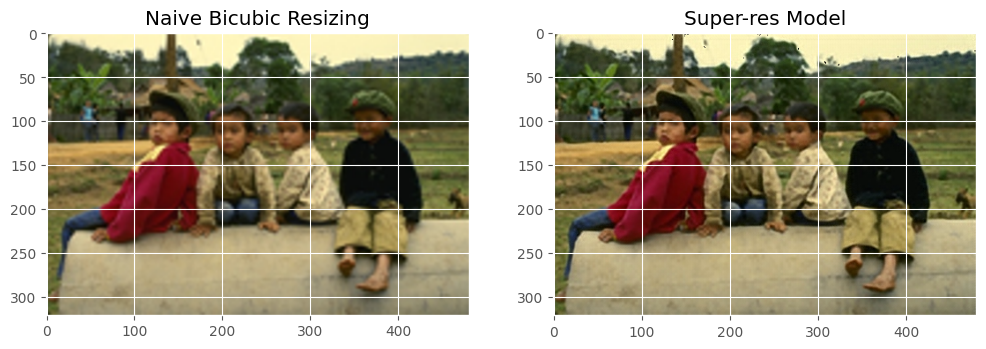

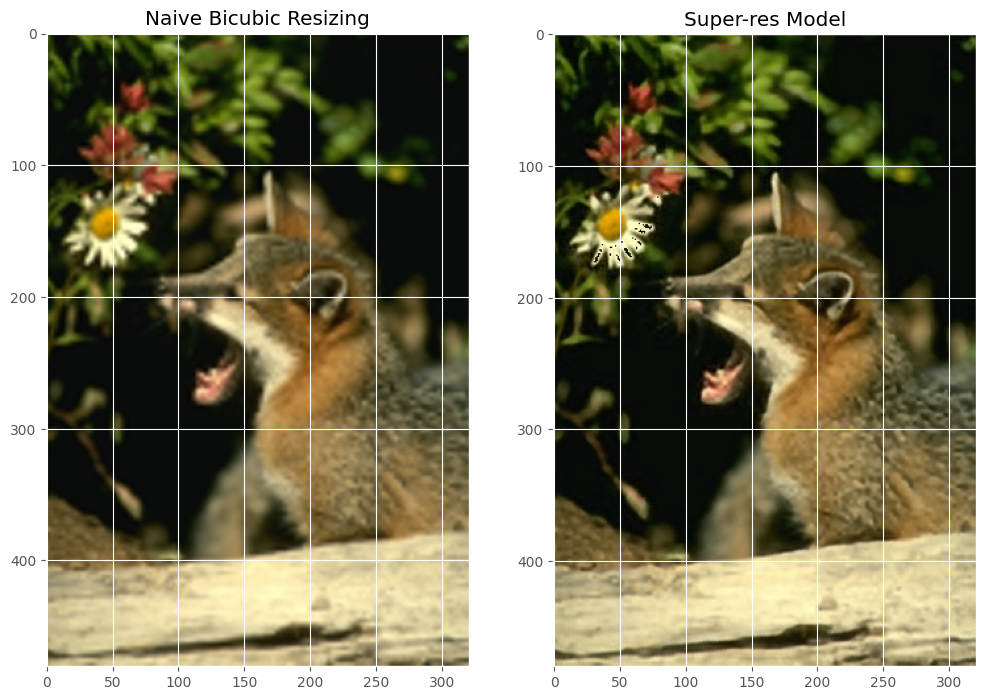

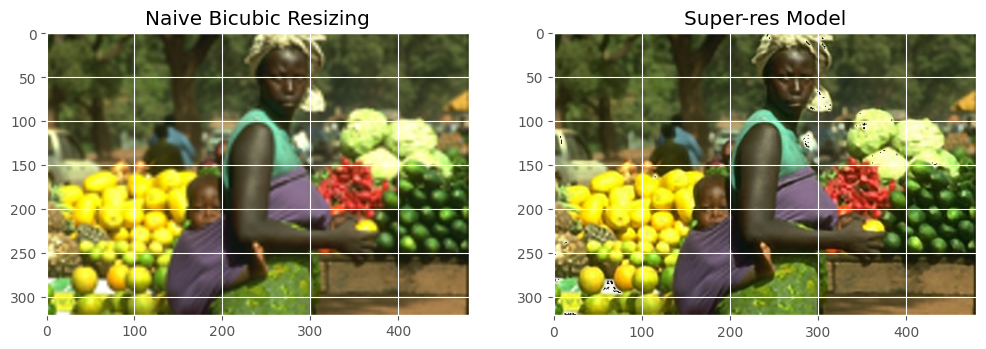

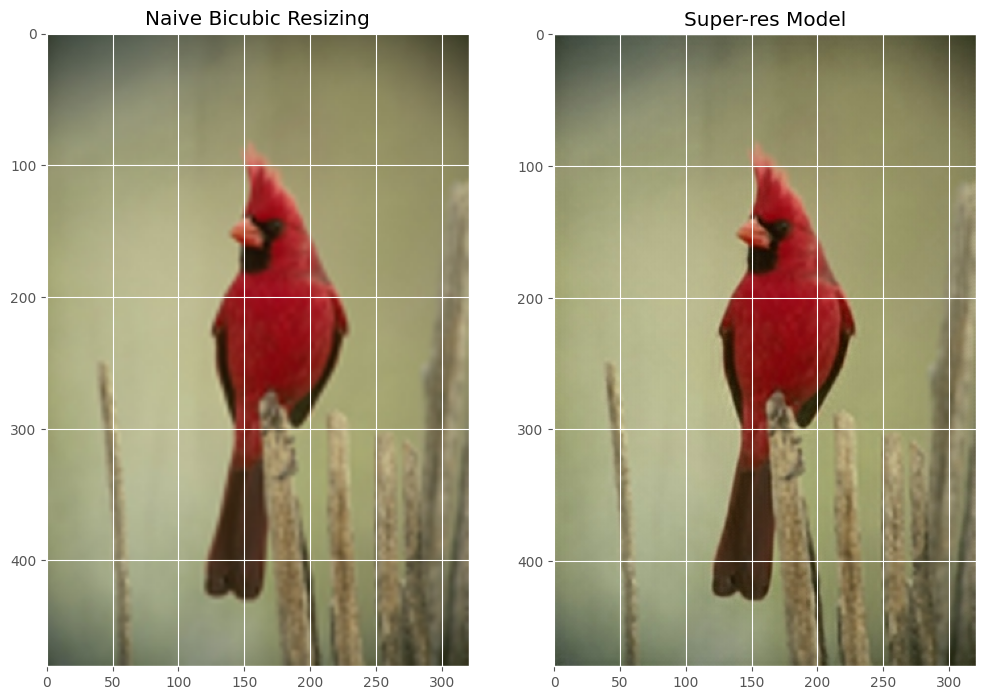

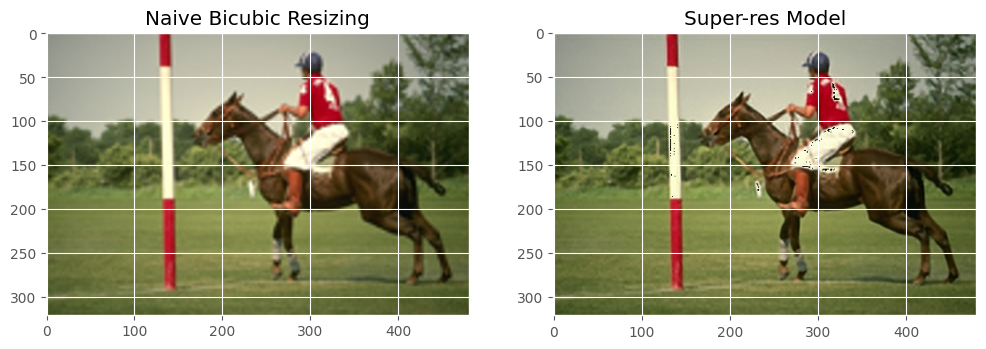

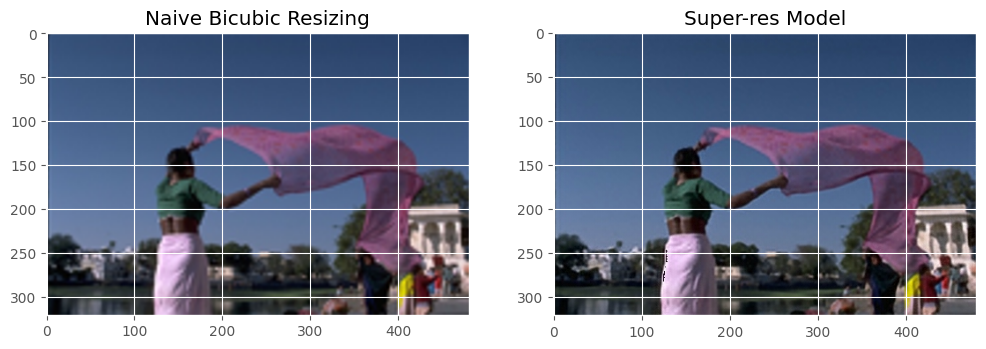

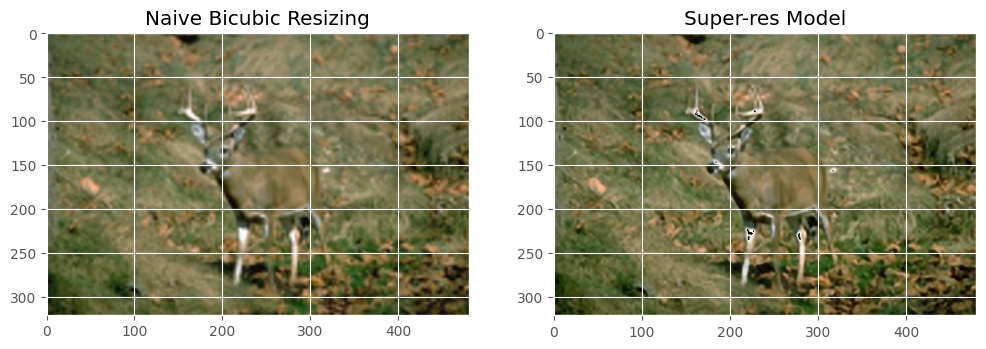

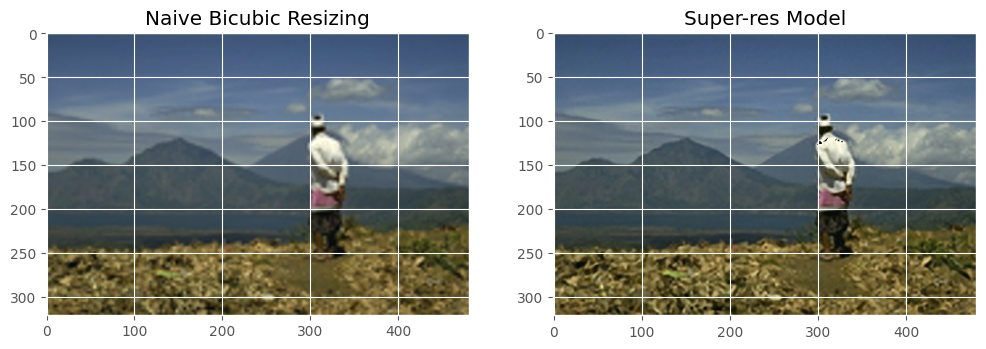

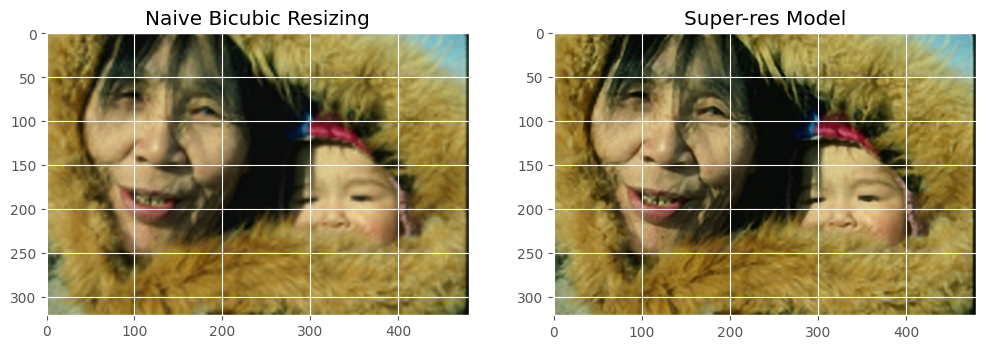

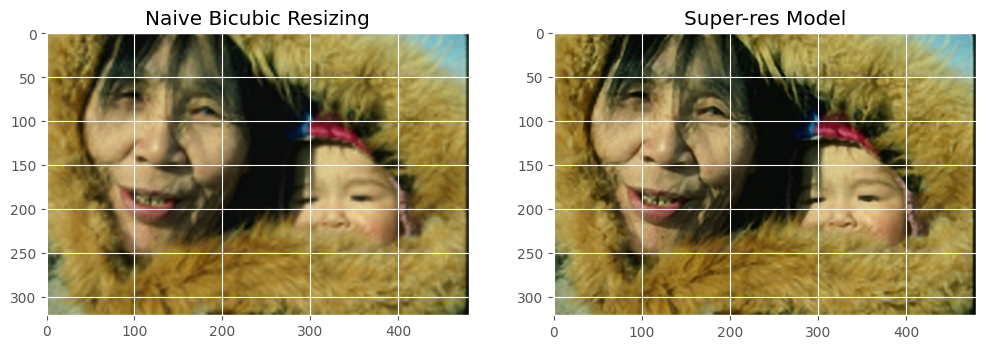

In [67]:
# load the test image paths from disk and select ten paths randomly
print("[INFO] loading test images...")
testPaths = list(paths.list_images(TEST_SET))
currentTestPaths = np.random.choice(testPaths, 10)
# load our super-resolution model from disk
print("[INFO] loading model...")
superResModel = load_model(SUPER_RES_MODEL,
    custom_objects={"psnr" : psnr})
# iterate through our test image paths
print("[INFO] performing predictions...")
for (i, path) in enumerate(currentTestPaths):
    # grab the original and the downsampled images from the
    # current path
    (orig, downsampled) = load_image(path)
    # retrieve the individual channels of the current image and perform
    # inference
    (y, cb, cr) = get_y_channel(downsampled)
    upscaledY = superResModel.predict(y[None, ...])[0]
    # postprocess the output and apply the naive bicubic resizing to
    # the downsampled image for comparison
    finalOutput = postprocess_image(upscaledY, cb, cr)
    naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)
    # visualize the results and save them to disk
    path = os.path.join(VISUALIZATION_PATH, f"{i}_viz.png")
    (fig, (ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 12))
    ax1.imshow(naiveResizing)
    ax2.imshow(finalOutput.astype("int"))
    ax1.set_title("Naive Bicubic Resizing")
    ax2.set_title("Super-res Model")
    #fig.savefig(path, dpi=300, bbox_inches="tight")

In [69]:
for layer in model.layers:
    print(layer.get_output_at(0).get_shape())
    

(None, None, None, 1)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 64)
(None, None, None, 192)
(None, None, None, 64)
(None, None, None, 256)
(None, None, None, 64)
(None, None, None, 64)
(None, None, None, 32)
(None, None, None, 32)
(None, None, None, 32)
(None, None, None, 64)
(None, None, None, 32)
(None, None, None, 96)
(None, None, None, 32)
(None, None, None, 128)
(None, None, None, 32)
(None, None, None, 32)
(None, None, None, 9)
(None, None, None, 1)
